# Investment and Trading Capstone Project
## Build a Stock Price Indicator

## 1. Introduction
Financial institutions around the world are trading in billions of dollars on a daily basis. Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades.  A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

UK banking stock prices have been in a general downtrend since the crash of 2008 but in that time there have also been system shocks such as Brexit, a pandemic and incompetent government borrowing strategies. Since 2008 the inflation and interest rate environment in the UK was largely that of low rates and low inflation, since the pandemic we have entered a period of greater interest rates and inflation. While higher interest rates should be good for bank profits and therefore stock prices, volatility in rates can cause hedging strategies to quickly become unprofitable if the bank does not act quickly enough.

In this project, I will be specifically looking at UK based bank stock prices and building a stock price predictor that takes daily trading data over a certain date range as input as well as the UK 10 year forward rate (the projected bank of England funding rate for lending in 10 years time), and outputs projected estimates for given query dates.

My objective in this project is to use metrics specific for the bank as well as projected UK interest rates to predict a stock price for a bank at a moment in time.
The input metrics relating to the individual banks will include opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close); I will be predicting the Adjusted Close price.

### Install and import relevant libraries

In [2]:
pip install numpy==1.23.5 --user

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
pip install sklearn --upgrade --user

Requirement already up-to-date: sklearn in c:\users\danny\anaconda3\lib\site-packages (0.0.post1)
Note: you may need to restart the kernel to use updated packages.


In [128]:
# imports

import numpy as np
import numexpr
import pandas as pd
#from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import display
import seaborn as sns
%matplotlib inline

#import functions
import plotting
from datetime import datetime,date

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import mean_squared_error
from keras.layers import LSTM

# Needed to help our plots look cleaner with plotly 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected=True)

import yfinance as yfin
import requests     # 2.19.1
import io

## 2. Exploratory Analysis
In this section we will pull the data, and compute some statistics and plots before we start the modelling process.
### Getting the Data
The data I will be using for the UK bank stocks is from [yahoo finance](https://finance.yahoo.com/).

The data I will use for UK forward rates will come from the [bank_of_england](https://www.bankofengland.co.uk/boeapps/database/default.asp/).



In [203]:
# Download stock data then export as CSV
#tickers are for equity markets FTSE index, UK Banking index, Barclays, NatWest, LLoyds, HSBC and Standard Chartered 
equity_tickers = ("^FTSE", "^BUKFIN", "BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L") 

start = "2001-01-01"
end = '2022-12-31'


# stock data downloaded from yahoo finance for our 5 big banks, FTSE 100 and UK banking index
df_bukfin = yfin.download(equity_tickers, start, end) 

[*********************100%***********************]  7 of 7 completed


In [204]:
df_bukfin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5650 entries, 2001-01-01 to 2022-12-30
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BARC.L)   5599 non-null   float64
 1   (Adj Close, HSBA.L)   5600 non-null   float64
 2   (Adj Close, LLOY.L)   5598 non-null   float64
 3   (Adj Close, NWG.L)    5600 non-null   float64
 4   (Adj Close, STAN.L)   5600 non-null   float64
 5   (Adj Close, ^BUKFIN)  3096 non-null   float64
 6   (Adj Close, ^FTSE)    5557 non-null   float64
 7   (Close, BARC.L)       5599 non-null   float64
 8   (Close, HSBA.L)       5600 non-null   float64
 9   (Close, LLOY.L)       5598 non-null   float64
 10  (Close, NWG.L)        5600 non-null   float64
 11  (Close, STAN.L)       5600 non-null   float64
 12  (Close, ^BUKFIN)      3096 non-null   float64
 13  (Close, ^FTSE)        5557 non-null   float64
 14  (High, BARC.L)        5599 non-null   float64
 15  (Hi

In [205]:
## use requests to csv query the bank of England database for UK 10 year forwards

payload = {
    'Datefrom'   : '31/Dec/2000',
    'Dateto'     : '01/Jan/2023',
    'SeriesCodes': 'IUDMNIF',
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}

headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}


url_endpoint = 'https://www.bankofengland.co.uk/boeapps/database/_iadb-fromshowcolumns.asp?csv.x=yes'


response = requests.get(url_endpoint, params=payload, headers=headers)
print(response.status_code)

200


In [206]:
df_yields = pd.read_csv(io.BytesIO(response.content))

In [207]:
df_yields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     5559 non-null   object 
 1   IUDMNIF  5559 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.0+ KB


In [208]:
df_yields.head(50)

,DATE,IUDMNIF
0,02 Jan 2001,4.0707
1,03 Jan 2001,3.9272
2,04 Jan 2001,4.0104
3,05 Jan 2001,4.0723
4,08 Jan 2001,4.1021
5,09 Jan 2001,4.1487
6,10 Jan 2001,4.1192
7,11 Jan 2001,4.1228
8,12 Jan 2001,4.1748
9,15 Jan 2001,4.1677


In [214]:
df_yields.tail()

IUDMNIF                                                
             ^FTSE ^BUKFIN  BARC.L   NWG.L  LLOY.L  HSBA.L  STAN.L
Date                                                              
2022-12-22  4.1255  4.1255  4.1255  4.1255  4.1255  4.1255  4.1255
2022-12-23  4.1526  4.1526  4.1526  4.1526  4.1526  4.1526  4.1526
2022-12-28  4.2292  4.2292  4.2292  4.2292  4.2292  4.2292  4.2292
2022-12-29  4.2654  4.2654  4.2654  4.2654  4.2654  4.2654  4.2654
2022-12-30  4.2659  4.2659  4.2659  4.2659  4.2659  4.2659  4.2659

In [ ]:
## Lets prep the BoE data to be merged with our stock data

In [210]:
df_yields['Date'] = pd.to_datetime(df_yields['DATE'].astype(str))

In [211]:
df_yields = df_yields.drop(columns=['DATE']).set_index('Date')

In [212]:
for x in equity_tickers:
    df_yields[str(x)] = df_yields['IUDMNIF']

df_yields = df_yields.drop(columns=['IUDMNIF'])
df_yields.columns = pd.MultiIndex.from_tuples([('IUDMNIF', c) for c in df_yields.columns])

In [213]:
## merge our datasets
df_bukfin = pd.merge(df_bukfin, df_yields, how='left', on=['Date'])

In [ ]:
df_bukfin.to_csv('./data/data.csv') #convert data to csv

### View the Data

In [215]:
#check the dimensions of the data
df_bukfin.shape

(5650, 49)

In [216]:
#view the first 5 rows of the data
df_bukfin.head()

Adj Close                                                   \
                BARC.L      HSBA.L      LLOY.L        NWG.L      STAN.L   
Date                                                                      
2001-01-01  235.636627  301.498932  190.469543  2743.863037  408.418671   
2001-01-02  236.887527  292.928345  188.855392  2677.157227  402.278748   
2001-01-03  238.252182  290.785828  191.007584  2671.953857  398.044250   
2001-01-04  249.624634  317.109589  201.768585  2786.547607  429.802948   
2001-01-05  250.193237  314.048767  202.037552  2849.039062  438.060516   

                                      Close                          ...  \
           ^BUKFIN        ^FTSE      BARC.L      HSBA.L      LLOY.L  ...   
Date                                                                 ...   
2001-01-01     NaN          NaN  478.499786  858.365295  459.938904  ...   
2001-01-02     NaN  6174.700195  481.040100  833.965088  456.041107  ...   
2001-01-03     NaN  6039.899902  483.811310  827.864990  461.238190  ...   
2001-01-04     NaN  6185.600098  506.904907  902.808594  487.223389  ...   
2001-01-05     NaN  6198.100098  508.059601  894.094177  487.872986  ...   

                Volume                       IUDMNIF                          \
                STAN.L ^BUKFIN         ^FTSE   ^FTSE ^BUKFIN  BARC.L   NWG.L   
Date                                                                           
2001-01-01         0.0     NaN           NaN     NaN     NaN     NaN     NaN   
2001-01-02   3413554.0     NaN  7.090540e+08  4.0707  4.0707  4.0707  4.0707   
2001-01-03   4307775.0     NaN  1.147114e+09  3.9272  3.9272  3.9272  3.9272   
2001-01-04  15291828.0     NaN  1.640397e+09  4.0104  4.0104  4.0104  4.0104   
2001-01-05  12845501.0     NaN  1.293875e+09  4.0723  4.0723  4.0723  4.0723   

                                    
            LLOY.L  HSBA.L  STAN.L  
Date                                
2001-01-01     NaN     NaN     NaN  
2001-01-02  4.0707  4.0707  4.0707  
2001-01-03  3.9272  3.9272  3.9272  
2001-01-04  4.0104  4.0104  4.0104  
2001-01-05  4.0723  4.0723  4.0723  

[5 rows x 49 columns]

In [170]:
#view the last 5 values of the data
df_bukfin.tail()

,"(Adj Close, BARC.L)","(Adj Close, HSBA.L)","(Adj Close, LLOY.L)","(Adj Close, NWG.L)","(Adj Close, STAN.L)","(Adj Close, ^BUKFIN)","(Adj Close, ^FTSE)","(Close, BARC.L)","(Close, HSBA.L)","(Close, LLOY.L)",...,"(Open, ^BUKFIN)","(Open, ^FTSE)","(Volume, BARC.L)","(Volume, HSBA.L)","(Volume, LLOY.L)","(Volume, NWG.L)","(Volume, STAN.L)","(Volume, ^BUKFIN)","(Volume, ^FTSE)",IUDMNIF
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-22,157.139999,512.299988,46.099998,264.600006,625.000000,NaN,7469.299805,157.139999,512.299988,46.099998,...,NaN,7497.299805,18858465.0,26334928.0,56008053.0,8391799.0,3471945.0,NaN,402305900.0,4.1255
2022-12-23,157.740005,510.299988,46.029999,264.500000,625.000000,NaN,7473.000000,157.740005,510.299988,46.029999,...,NaN,7469.299805,6137843.0,19354109.0,21260125.0,3059799.0,1020433.0,NaN,222853700.0,4.1526
2022-12-28,158.880005,518.000000,46.240002,267.500000,629.200012,NaN,7497.200195,158.880005,518.000000,46.240002,...,NaN,7473.000000,15974901.0,24836592.0,163534062.0,8234805.0,3458610.0,NaN,416900400.0,4.2292
2022-12-29,159.339996,518.799988,46.224998,267.899994,629.799988,NaN,7512.700195,159.339996,518.799988,46.224998,...,NaN,7497.200195,17312328.0,8053077.0,57363872.0,7921721.0,2703538.0,NaN,351759900.0,4.2654
2022-12-30,158.520004,515.700012,45.410000,265.200012,622.400024,NaN,7451.700195,158.520004,515.700012,45.410000,...,NaN,7512.700195,9144860.0,8437810.0,70883064.0,3289465.0,2506663.0,NaN,254135300.0,4.2659


In [217]:
#check if there are missing values for each type of stock
df_bukfin.isnull().sum()

Adj Close  BARC.L       51
           HSBA.L       50
           LLOY.L       52
           NWG.L        50
           STAN.L       50
           ^BUKFIN    2554
           ^FTSE        93
Close      BARC.L       51
           HSBA.L       50
           LLOY.L       52
           NWG.L        50
           STAN.L       50
           ^BUKFIN    2554
           ^FTSE        93
High       BARC.L       51
           HSBA.L       50
           LLOY.L       52
           NWG.L        50
           STAN.L       50
           ^BUKFIN    2554
           ^FTSE        93
Low        BARC.L       51
           HSBA.L       50
           LLOY.L       52
           NWG.L        50
           STAN.L       50
           ^BUKFIN    2554
           ^FTSE        93
Open       BARC.L       51
           HSBA.L       50
           LLOY.L       52
           NWG.L        50
           STAN.L       50
           ^BUKFIN    2554
           ^FTSE        93
Volume     BARC.L       51
           HSBA.L       50
 

Lets use the `fillna` method to resolve the missing values.

In [218]:
# handing missing values
df_bukfin.fillna(method='ffill', inplace = True) # use front fill method
df_bukfin.fillna(method='bfill', inplace = True) # use back fill method

In [219]:
#check to see if there are still any missing values
df_bukfin.isnull().sum()

Adj Close  BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE      0
Close      BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE      0
High       BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE      0
Low        BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE      0
Open       BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE      0
Volume     BARC.L     0
           HSBA.L     0
           LLOY.L     0
           NWG.L      0
           STAN.L     0
           ^BUKFIN    0
           ^FTSE

Finally, we have no missing values. We will now check some descriptive statistics of the data.

In [220]:
#view descriptive statistics of adjusted close process of the stocks
df_bukfin[['Adj Close']].describe()

Adj Close                                                      \
            BARC.L       HSBA.L       LLOY.L        NWG.L       STAN.L   
count  5650.000000  5650.000000  5650.000000  5650.000000  5650.000000   
mean    210.741000   378.038549    93.020754  1270.493666   685.556201   
std      76.721783    95.058882    68.948582  1429.490713   269.796575   
min       1.546823   154.807571    15.817207    84.229324   246.476883   
25%     159.866737   312.685303    43.745171   208.937943   455.879677   
50%     193.599358   364.424988    52.667740   289.487366   626.964386   
75%     249.141346   421.393524   152.461060  2902.480957   904.325729   
max     455.730286   629.013550   247.164536  4547.088379  1351.996216   

                                  
            ^BUKFIN        ^FTSE  
count   5650.000000  5650.000000  
mean   10694.190151  5992.318707  
std     1151.785341  1048.632236  
min     6996.763184  3287.000000  
25%    10259.739258  5260.474854  
50%    10259.739258  6037.400146  
75%    11439.811768  6834.199829  
max    13963.120117  7877.500000

In [106]:
# view general info
df_bukfin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5650 entries, 2001-01-01 to 2022-12-30
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BARC.L)   5650 non-null   float64
 1   (Adj Close, HSBA.L)   5650 non-null   float64
 2   (Adj Close, LLOY.L)   5650 non-null   float64
 3   (Adj Close, NWG.L)    5650 non-null   float64
 4   (Adj Close, STAN.L)   5650 non-null   float64
 5   (Adj Close, ^BUKFIN)  5650 non-null   float64
 6   (Adj Close, ^FTSE)    5650 non-null   float64
 7   (Close, BARC.L)       5650 non-null   float64
 8   (Close, HSBA.L)       5650 non-null   float64
 9   (Close, LLOY.L)       5650 non-null   float64
 10  (Close, NWG.L)        5650 non-null   float64
 11  (Close, STAN.L)       5650 non-null   float64
 12  (Close, ^BUKFIN)      5650 non-null   float64
 13  (Close, ^FTSE)        5650 non-null   float64
 14  (High, BARC.L)        5650 non-null   float64
 15  (Hi

In [221]:
# View the maximum close date of stocks
def max_close(stocks,df):
    """ This calculates and returns the maximum closing value of a specific stock"""
    
    return df['Close'][stocks].max() # computes and returns the maximum closing stock value

In [222]:
# test the above function with specific stocks
def test_max():
    """ This tests the max_close function"""
    for stocks in ["^FTSE", "^BUKFIN", "BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]:
        print("Maxiumum Closing Value for {} is {}".format(stocks, max_close(stocks,df_bukfin)))

test_max()        

Maxiumum Closing Value for ^FTSE is 7877.5
Maxiumum Closing Value for ^BUKFIN is 13963.1201171875
Maxiumum Closing Value for BARC.L is 729.7584228515625
Maxiumum Closing Value for NWG.L is 6652.673828125
Maxiumum Closing Value for LLOY.L is 530.7487182617188
Maxiumum Closing Value for HSBA.L is 951.6090698242188
Maxiumum Closing Value for STAN.L is 1856.0062255859375


In [223]:
# calculate the mean volume for the stocks
def mean_vol(stocks,df):
    """ This calculates and returns the minimum volume of a specific stock"""
    return df['Volume'][stocks].mean() # computes and returns the minimum volume of a stock

In [224]:
# test the above function with specific stocks
def test_mean():
    """ This tests the max_close function"""
    for stocks in ["^FTSE", "^BUKFIN", "BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]:
        print("Mean Volume for {} is {}".format(stocks, mean_vol(stocks,df_bukfin)))

test_mean()        

Mean Volume for ^FTSE is 1089722169.4513273
Mean Volume for ^BUKFIN is 0.0
Mean Volume for BARC.L is 68952677.54123893
Mean Volume for NWG.L is 11507988.909734514
Mean Volume for LLOY.L is 132346894.87628318
Mean Volume for HSBA.L is 34110765.78867257
Mean Volume for STAN.L is 7691482.5270796465


### Plotting stock prices

In [114]:
# Plot function for the Adjusted closing value
def plot_adj(df,title,stocks,y=0):
        ax = df['Adj Close'][stocks].plot(title=title, figsize=(16,8), ax=None)
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        ax.axhline(y=y,color='black')
        ax.legend(stocks, loc='upper left')
        plt.show()

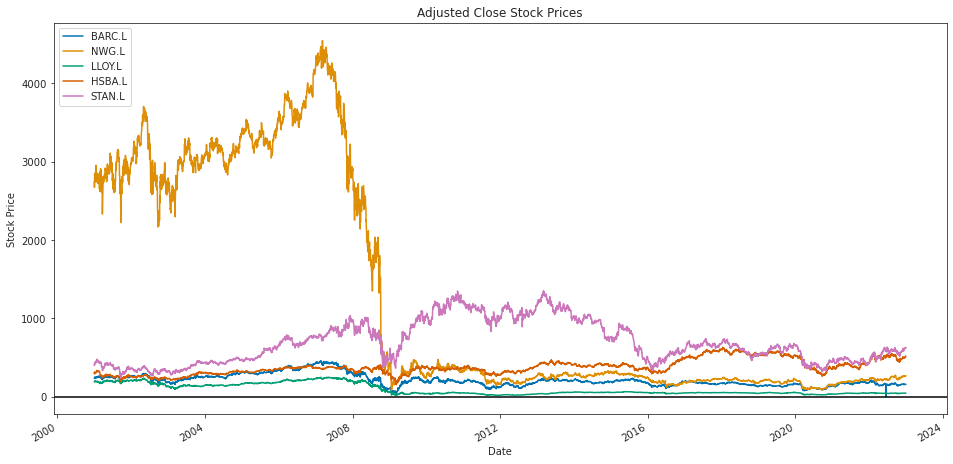

In [225]:
# View the plot of Adjusted close
stocks = ["BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]
plot_adj(df_bukfin,"Adjusted Close Stock Prices",stocks)

From the plot above, we can see NatWest which now includes Royal Bank of Scotland had a huge collapse in the GFC of 2008. Only HSBC has recovered to its pre GFC price. Since the Brexit vote in 2016 the trend for each of the banks is largely similar. Given the drastic nature of the collapse in NatWest in 2008 it may be wise to only view data with a horizon which starts after prices stabilised.

In [226]:
# Plot function for the High prices
def plot_high(df,title,stocks,y=0):
        ax = df['High'][stocks].plot(title=title, figsize=(16,8), ax = None)
        ax.set_xlabel("Date")
        ax.set_ylabel("Stock Price")
        ax.axhline(y=y,color='black')
        ax.legend(stocks, loc='upper left')
        plt.show()

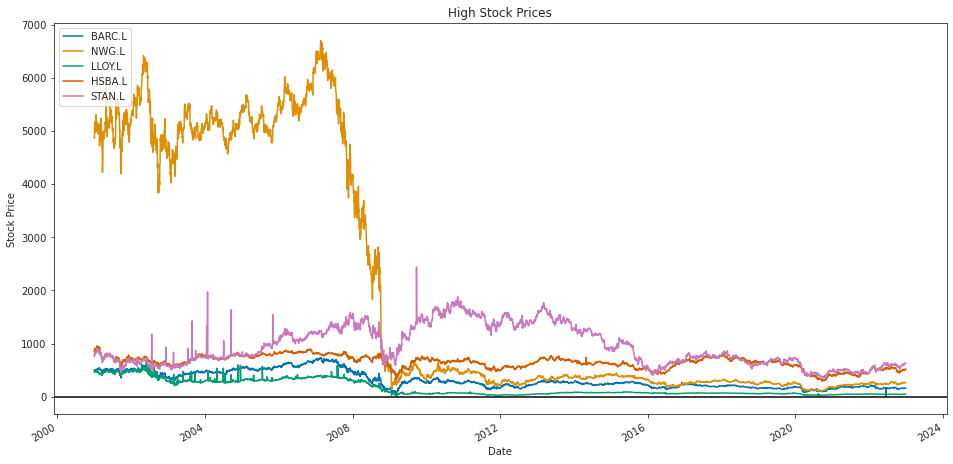

In [227]:
# View the plot of high stock prices
stocks = ["BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]
title = "High Stock Prices"
plot_high(df_bukfin,title,stocks)

The stock prices highs how HSBC and Standard Chartered out in front.

In [230]:
# view all stocks adjusted close price from Jan 2010 to Aug 2021
df_bukfin['Adj Close'].loc['2010-01-01':'2022-12-31']

,BARC.L,HSBA.L,LLOY.L,NWG.L,STAN.L,^BUKFIN,^FTSE
Date,,,,,,,
2010-01-04,185.510056,384.073608,37.848316,262.501312,1048.532593,10259.739258,5500.299805
2010-01-05,197.114685,389.624481,39.130203,289.487366,1063.474365,10259.739258,5522.500000
2010-01-06,202.999741,391.421936,39.535778,299.954712,1052.105347,10259.739258,5530.000000
2010-01-07,208.620361,389.360046,41.230476,293.330902,1042.360718,10259.739258,5526.700195
2010-01-08,211.959534,391.210449,41.208752,287.197632,1055.028809,10259.739258,5534.200195
...,...,...,...,...,...,...,...
2022-12-22,157.139999,512.299988,46.099998,264.600006,625.000000,10469.041016,7469.299805
2022-12-23,157.740005,510.299988,46.029999,264.500000,625.000000,10469.041016,7473.000000
2022-12-28,158.880005,518.000000,46.240002,267.500000,629.200012,10469.041016,7497.200195


In [231]:
# create function to plot data
def plot_data1(df,stocks,title,ylabel='Stock Price',y=0):
    """This funtion plots stock prices"""
    ax = df.plot(title=title, figsize=(16,8), ax=None, fontsize=2)
    ax.set_xlabel("Date")
    ax.set_label(ylabel)
    ax.axhline(y=y,color='black')
    ax.legend(stocks, loc='upper left')
    plt.show()

In [232]:
# create function to plot selected stocks
def selected_plot(df, columns,stocks, start_idx, end_idx):
    """This function plots specific stocks over a given date range"""
    plot_data1(df[columns].loc[start_idx:end_idx, stocks],stocks, title="Plot for selected banks")

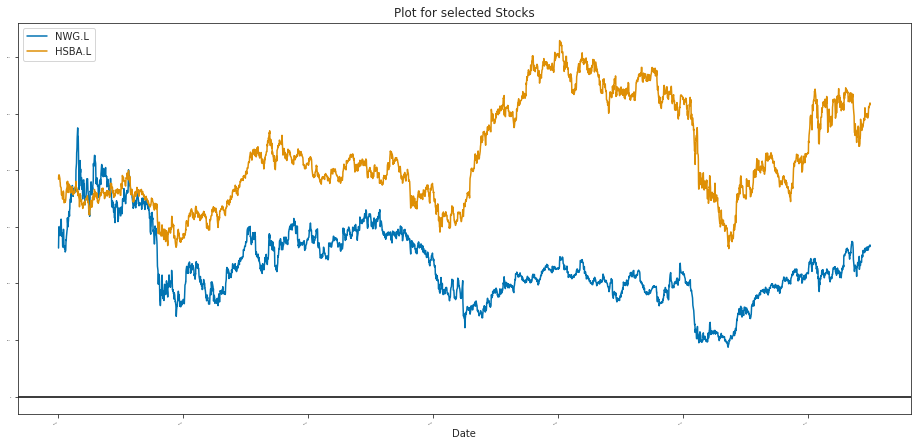

In [314]:
# create function to plot data based on specific columns, symbols, and date ranges
def test_select():
    """This function plots stock data based on specific columns, symbols, and date ranges """
    # specify columns to plot and stock symbols
    columns = 'Adj Close'
    stocks = ["NWG.L", "HSBA.L"]  
        
    # Get stock data
    df = df_bukfin

    # Slice and plot
    selected_plot(df, columns, stocks, '2010-01-01', '2022-12-31')
    
test_select()  # run the plot function  

### Normalizing the data
We want to know how the different types of stocks went up and down with respect to the others. In order to do this, we will normalize the data. We do this by dividing the values of each column by day one to ensure that each stock starts with ${$1}$.

In [235]:
def plot_data2(df,stocks,title='Stock Prices',ylabel="Stock Price",y=0, start='2001-01-01', end ='2021-08-17'):
    
    """ This function creates a plot of adjusted close stock prices
    inputs:
    df - dataframe
    title - plot title
    stocks - the stock symbols of each company
    ylabel - y axis label
    y - horizontal line(integer)
    output: the plot of adjusted close stock prices
    """
    df_new = df[start:end]
    #ax = df_new['Adj Close'][stocks].plot(title=title, figsize=(16,8), ax = None)
    ax = df_new.plot(title=title, figsize=(16,8), ax = None)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    ax.axhline(y=y,color='black')
    ax.legend(stocks, loc='upper left')
    plt.show()

In [236]:
# create function that normalizes the data
def normalize_data(df):
    """ 
    This function normalizes the stock prices using the first row of the dataframe
    input - stock data
    output - normalized stock data
    """
    return df/df.iloc[0,:]    

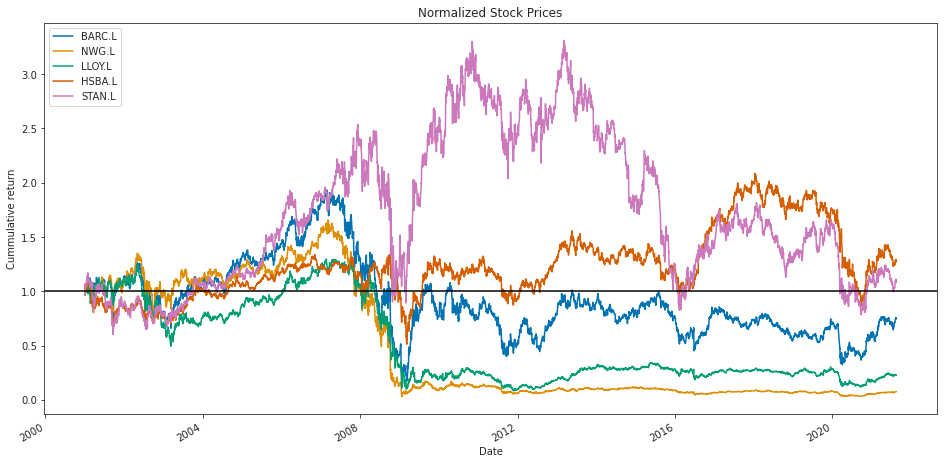

In [315]:
# plot the data with the new normalized data

stocks = ["BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]

plot_data2(normalize_data(df_bukfin['Adj Close'][stocks]),stocks,title = "Normalized Stock Prices", ylabel = 'Cummulative return',y=1)

From the above cummulative return plot, we can see that Standard 

### Cumulative Return
Let's have a look at how the pandemic affected stock prices for these companies.

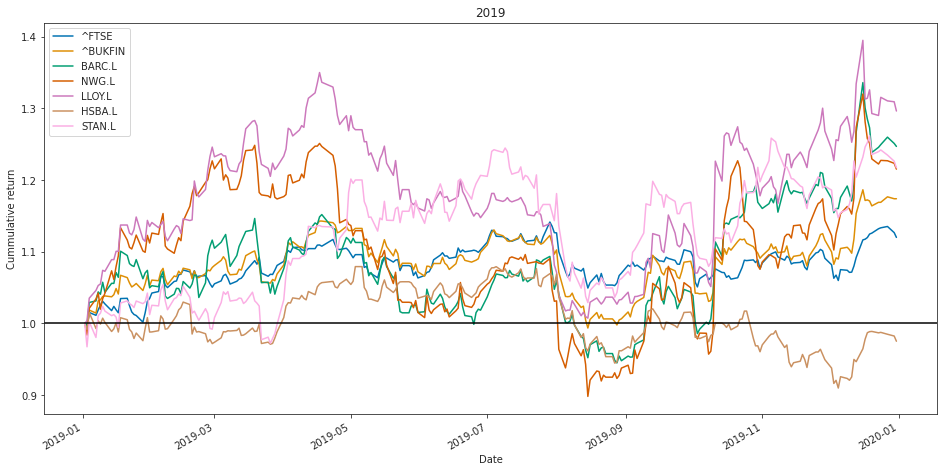

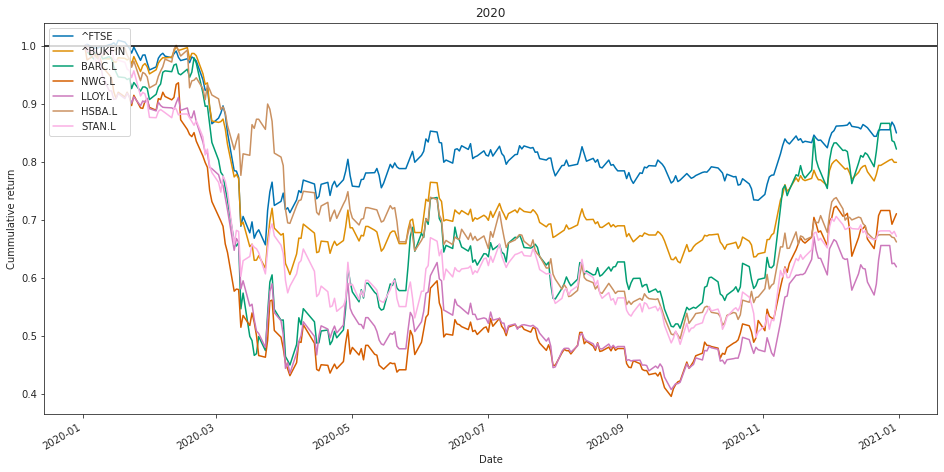

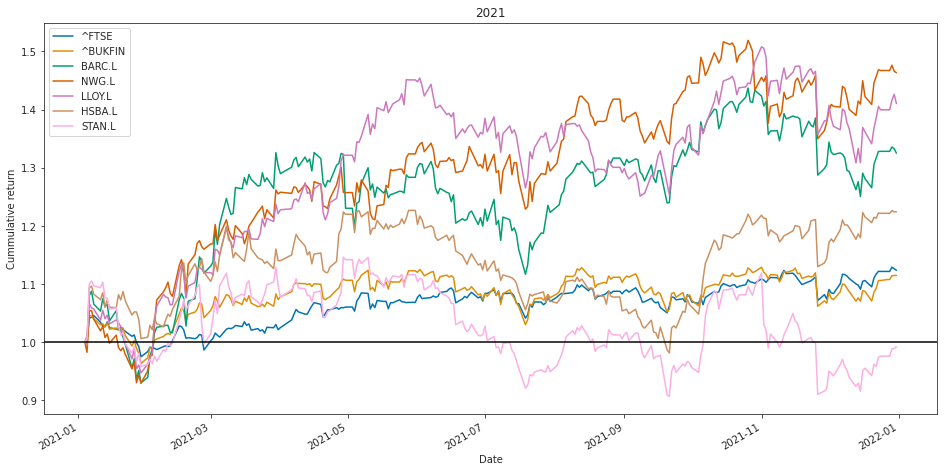

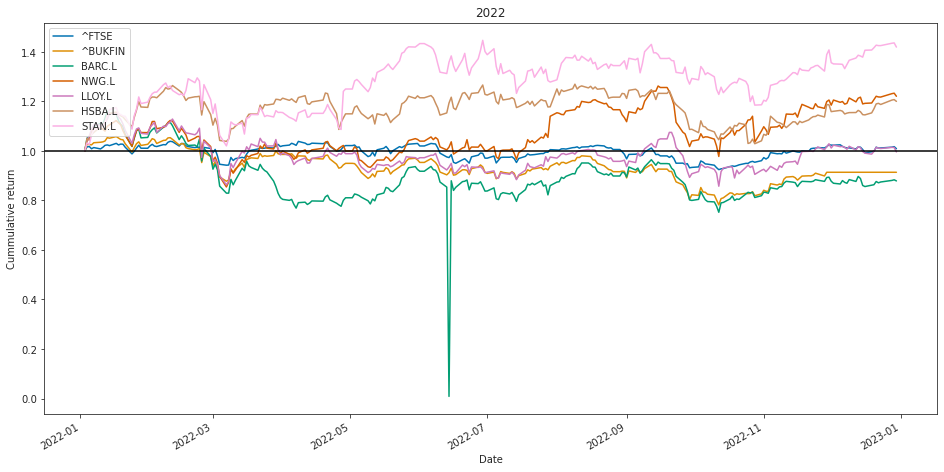

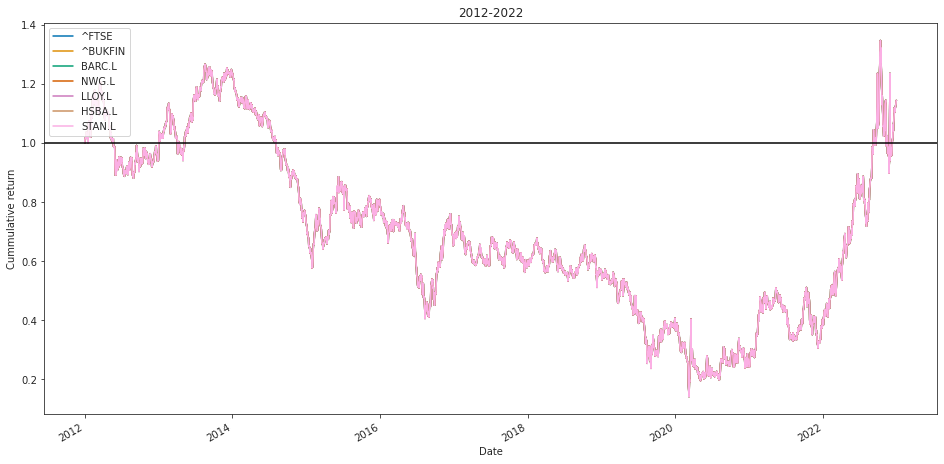

In [318]:
stocks = ["^FTSE", "^BUKFIN", "BARC.L", "NWG.L", "LLOY.L", "HSBA.L", "STAN.L"]

plot_data2(normalize_data(df_bukfin['Adj Close'][stocks]['2019-01-01':'2019-12-31']), stocks,title = '2019', ylabel = 'Cummulative return',y=1, start='2019-01-01', end = '2019-12-31') #2019
plot_data2(normalize_data(df_bukfin['Adj Close'][stocks]['2020-01-01':'2020-12-31']), stocks,title = '2020', ylabel = 'Cummulative return',y=1, start='2020-01-01', end = '2020-12-31') #2020
plot_data2(normalize_data(df_bukfin['Adj Close'][stocks]['2021-01-01':'2021-12-31']), stocks,title = '2021', ylabel = 'Cummulative return',y=1, start='2021-01-01', end = '2021-12-31') #2021
plot_data2(normalize_data(df_bukfin['Adj Close'][stocks]['2022-01-01':'2022-12-31']), stocks,title = '2022', ylabel = 'Cummulative return',y=1, start='2022-01-01', end = '2022-12-31') #2022
plot_data2(normalize_data(df_bukfin['IUDMNIF'][stocks]['2012-01-01':'2022-12-31']), stocks,title = '2012-2022', ylabel = 'Cummulative return',y=1, start='2012-01-01', end = '2022-12-31') #2022

From the above plots, let's take note of the following:

    1. 2019: Before the pandemic we see there isn't much annual grouwth in the stock prices for all 5 banks yet this is still outperforming the FTSE with the exception of HSBC.
    2. 2020: After the crash in Spring 2020 all the banks are hit more than FTSE but Barclays bounces back the fastest.
    3. 2021: All banks except Standard Chartered find price growth in 2021.
    4. 2022: We can see UK 10year forward rates growing by 300% but the curve does show volatility. Standard Chartered performs the best 2022 but it is difficult to assess correlation with UK yields.

### Computing the Rolling mean and Bollinger Bands
The rolling mean may give us some idea about the true underlying prices of a stock. If there is a significant deviation below or above the rolling mean, it may give us an idea about a potential buying and selling opportunity respectively. The challenge remains to know when this deviation is significant enough to pay attention to it. [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) is a statistical chart that contains the volatility of a financial instrument over time. `Bollinger` observed that looking at the recent volatility of the stock, if it is very volatile, we might discard the movement above and below the mean. But if it is not very volatile we may want to pay attention to it. He added a band  $2\delta$ (2 standard deviations)  above and below the mean. We would use the rolling standard deviation to help us achieve this.

In [239]:
# compute rolling mean, rolling standard deviation, upper and lower bands

def rolling_stats(df, stocks, type_, window = 20):
    """
    This function computes the rolling mean and Bollinger bands
    inputs : 
    df - dataframe
    stocks - the type of stocks we would be analyzing
    type_ - the price type of the rolling calculation
    window - number of days used to calculate the statistics
    output: 
    rolling mean, rolling standard deviation, upper and lower bands of 2 std each
    """
    
    val = df[(type_,stocks)]
    rolling_mean = df[(type_, stocks)].rolling(window=window).mean()
    rolling_std = df[(type_, stocks)].rolling(window=window).std()
    upper_band = rolling_mean + rolling_std*2
    lower_band = rolling_mean - rolling_std*2
    
    return val, rolling_mean, rolling_std, upper_band, lower_band
    

In [240]:
# plot the rolling mean, rolling standard deviation, upper and lower bands

def rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean'):
    """
    This function plots the rolling mean and Bollinger bands
    inputs : 
    stocks - the type of stocks we would be analyzing
    val - value of the stock price type
    rolling_mean - rolling mean
    upper_band - stocks upper band
    lower_band - stocks lower band
    title - plot title
    output: 
    plot of rolling mean, rolling standard deviation, upper and lower bands of 2 std each
    """
    
    ax = rolling_mean.plot(title=title, figsize=(16,8), label='Rolling Mean')
    plt.plot(upper_band, label = 'Upper Band')
    plt.plot(lower_band, label = 'Lower Band')
    plt.plot(val, label = 'Value of Stock')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.show()
    
    return ax


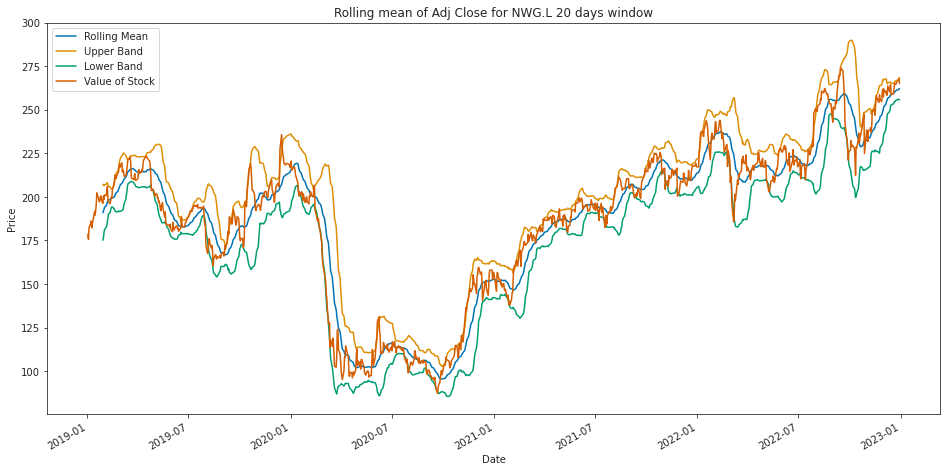

In [242]:
# view rolling statistics for NatWest

stocks = 'NWG.L'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(df_bukfin['2019-01-01':'2022-12-31'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

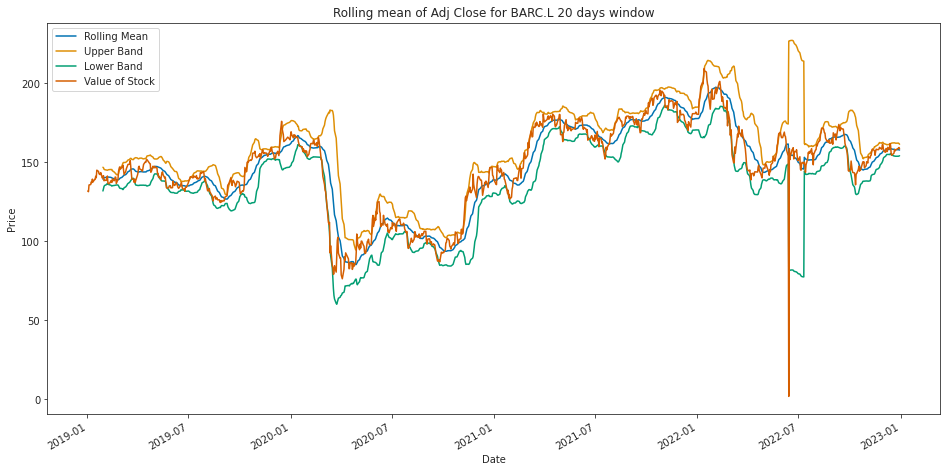

In [244]:
# view rolling statistics for Barclays
stocks = 'BARC.L'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(df_bukfin['2019-01-01':'2022-12-31'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

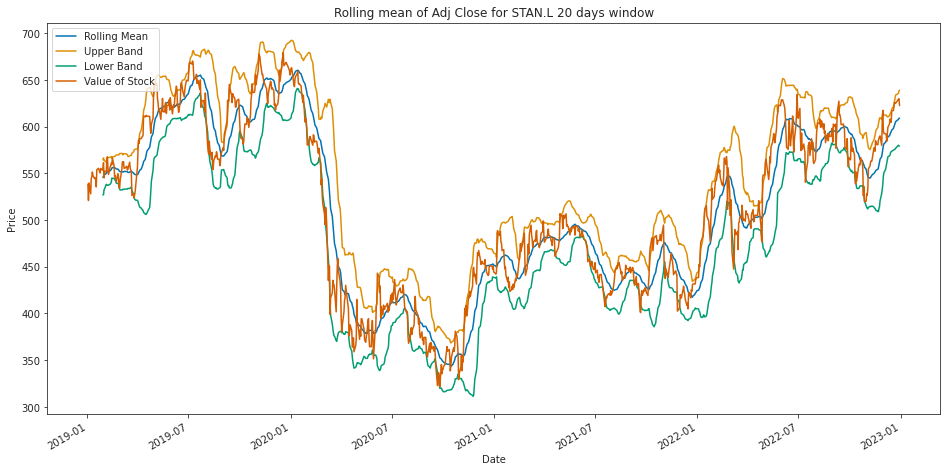

In [245]:
# view rolling statistics for Standard Chartered
stocks = 'STAN.L'
type_ = 'Adj Close'

val, rolling_mean, rolling_std, upper_band, lower_band = rolling_stats(df_bukfin['2019-01-01':'2022-12-31'], stocks, type_)

rolling_plot(stocks, val, rolling_mean, upper_band, lower_band, title='Rolling mean of {} for {} 20 days window'.format(type_,stocks))
plt.show()

From the above plots, we can see that the initial values for the rolling mean are missing. This is as a result of the 20 days window period we used at the beginning which had no values. We can also observe that the rolling mean follows the movement of the raw stock prices and it is less volatile. We can also see that NatWest and Standard Chartered have largely increasing stock prices since the pandemic while Barclays has been in decline since the start of 2022. In this data exploration session, I only considered a 20 days window and for 2 standard deviation away from the mean for simplicity. You may want to try computing different windows sizes and standard deviations to see how differently the stock prices behave.

### Computing Daily Returns
Daily returns tells us how much the stock price go up and down on a particular day. We can compute using the following function
$$
DailyReturn = \frac{price(t)}{price(t-1)} -1
$$
where `price(t)` is the price of today's stock and `price(t-1)` is the price of yesterday's stock.

In [43]:
def daily_returns_cal(df,stocks):
    """
    This function computes and returns the daily return values
    input: df (dataframe) and stocks
    output: daily return values
    """
    
    daily_returns = (df[('Adj Close', stocks)][1:]/df[('Adj Close', stocks)][:-1].values) - 1
       
    return daily_returns

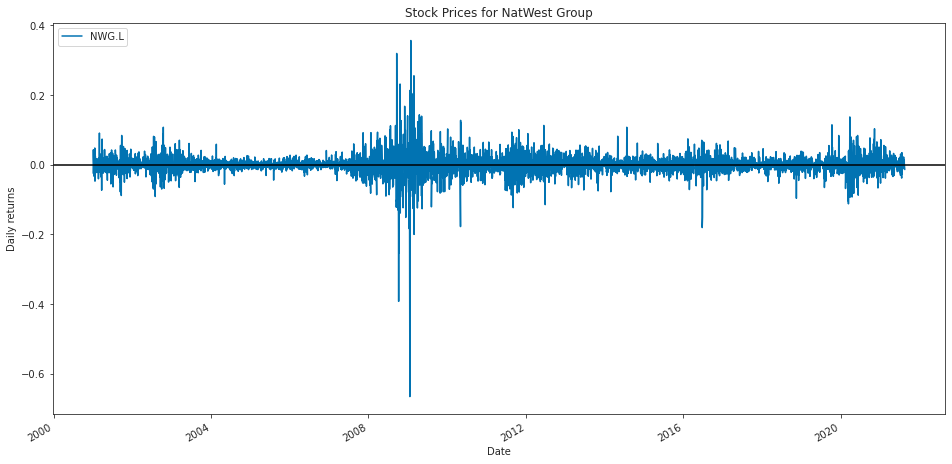

In [255]:
# Daily return of NatWest
plot_data2(daily_returns_cal(df_bukfin,'NWG.L'),stocks=['NWG.L'], ylabel = 'Daily returns',title='Stock Prices for NatWest Group',y=0)

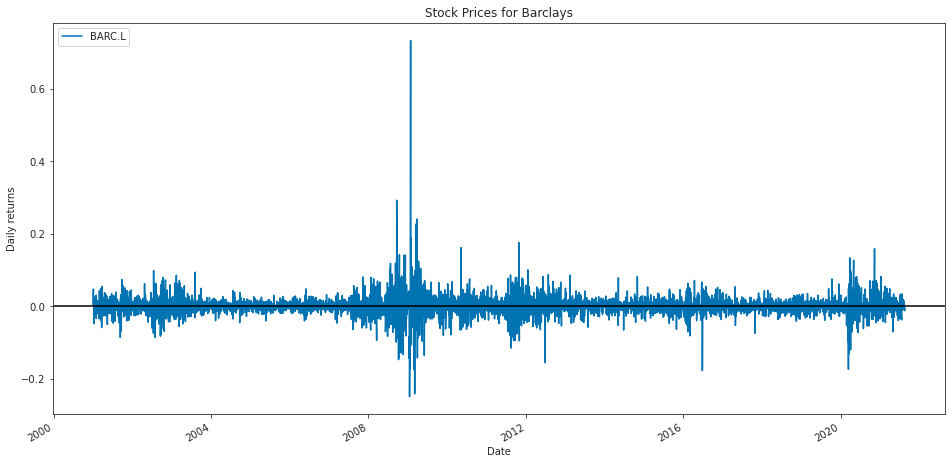

In [256]:
# Daily return of Ford
plot_data2(daily_returns_cal(df_bukfin,'BARC.L'),stocks=['BARC.L'], ylabel = 'Daily returns',title='Stock Prices for Barclays',y=0)

From the above plots, we can see that the volatility range for Barclays and NatWest is largely similar since the GFC but Barclays may have a slight more volatility since the pandemic.

## 3. Modelling
In this section I will be trying out some models to predict the Adjusted closing price of a stock.

### Predicting Adjusted close value of NatWest stocks


In [257]:
# Function that get specific stock data and fills in any missing value
def get_data(df, stocks):
    """
    This function gets a specific stock data and fills in any missing values using the fill forward and fill backward methods
    Input: 
    df - dataframe
    stocks - the type of stock
    Output - a cleaned dataset to be used for prediction
    """
    df1 = pd.DataFrame (data = df.iloc[:, df.columns.get_level_values(1)==stocks].values,
                          index = df.iloc[:, df.columns.get_level_values(1)==stocks].index,
                          columns = df.iloc[:, df.columns.get_level_values(1)==stocks].columns.get_level_values(0))
    
    df1.fillna(method='ffill', inplace= True)
    df1.fillna(method='bfill', inplace=True)
    
    return df1

In [258]:
# get NatWest data and view the first 5 rows
df_NWG = get_data(df_bukfin, 'NWG.L')  
df_NWG.head()

,Adj Close,Close,High,Low,Open,Volume,IUDMNIF
Date,,,,,,,
2001-01-01,2743.863037,4874.363281,4874.363281,4874.363281,4874.363281,0.0,4.0707
2001-01-02,2677.157227,4755.862305,4885.424316,4755.862305,4811.384766,1060102.0,4.0707
2001-01-03,2671.953857,4746.619141,4866.906738,4718.857910,4783.623535,2253620.0,3.9272
2001-01-04,2786.547607,4950.189941,4987.194336,4792.897949,4866.906738,5749990.0,4.0104
2001-01-05,2849.039062,5061.203613,5116.725586,4839.145508,4839.145508,3883576.0,4.0723


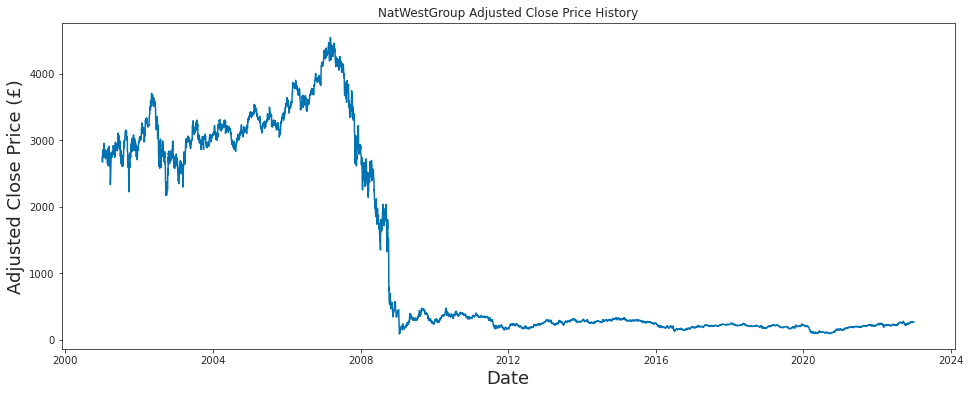

In [248]:
# plot showing NatWest historical Adjusted closing prices
plt.figure(figsize=(16,6))
plt.title('NatWestGroup Adjusted Close Price History')
plt.plot(df_NWG['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price (£)', fontsize=18)
plt.show()

#### Predicting using Long Short-Term Memory (LSTM) 
[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory#:~:text=Long%20short%2Dterm%20memory%20(LSTM)%20is%20an%20artificial%20recurrent,networks%2C%20LSTM%20has%20feedback%20connections.&text=A%20common%20LSTM%20unit%20is,gate%20and%20a%20forget%20gate.) is an artificial recurrent neural network (RNN) architecture used in deep learning that is capable of learning long-term dependencies. It processes data passing on information as it propagates forward and have a chain like structure. 

In [249]:
#view the shape
df_NWG.shape

(5650, 7)

In [250]:
# create the variables for prediction and split into training and test sets

y = np.log(df_NWG['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = df_NWG.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

In [252]:
# Build the LSTM model for NatWest stock
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [253]:
# view model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 6, 128)            66560     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [254]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Initial parameters used for LSTM

In [259]:
# Train the model - part 1
model.fit(np.array(xtrain).reshape(-1,6,1), ytrain, batch_size =1, epochs=5, verbose=0)

In [261]:
#predictions 
predictions = model.predict(np.array(xtest).reshape(-1,6,1))

36/36 [==============================] - 1s 7ms/step


In [262]:
#calculation of the mean absolute error
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.09922890079124148

In [263]:
# Train the model - part 2
model.fit(np.array(xtrain).reshape(-1,6,1), ytrain, batch_size =100, epochs=10, verbose=0)

In [264]:
#predictions 2
predictions = model.predict(np.array(xtest).reshape(-1,6,1))

36/36 [==============================] - 0s 6ms/step


In [265]:
#calculation of the mean absolute error 2
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.07735232671652384

### LSTM Refinement
#### Final Parameters used to tune LSTM

In [266]:
# Build the LSTM model with the relu activation function
model2 = Sequential()
model2.add(LSTM(128, activation='relu', return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model2.add(LSTM(64, activation='relu', return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

In [267]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

In [268]:
# view model2 summary
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 6, 128)            66560     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 25)                1625      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [269]:
# Train the model - part 3
model2.fit(np.array(xtrain).reshape(-1,6,1), ytrain, batch_size =1, epochs=5, verbose=0)

In [270]:
#predictions 3
predictions2 = model2.predict(np.array(xtest).reshape(-1,6,1))

36/36 [==============================] - 1s 6ms/step


In [271]:
#calculation of the mean absolute error 2
mean_abs_error2 = mean_absolute_error(ytest, predictions)
mean_abs_error2

0.07735232671652384

In [272]:
# Train the model - part 4 (increasing no. of epochs and batch_size)
model2.fit(np.array(xtrain).reshape(-1,6,1), ytrain, batch_size =100, epochs=10, verbose=0)

In [273]:
#predictions 3
predictions2 = model2.predict(np.array(xtest).reshape(-1,6,1))

36/36 [==============================] - 0s 8ms/step


In [274]:
#calculation of the mean absolute error 2
mean_abs_error2 = mean_absolute_error(ytest, predictions)
mean_abs_error2

0.07735232671652384

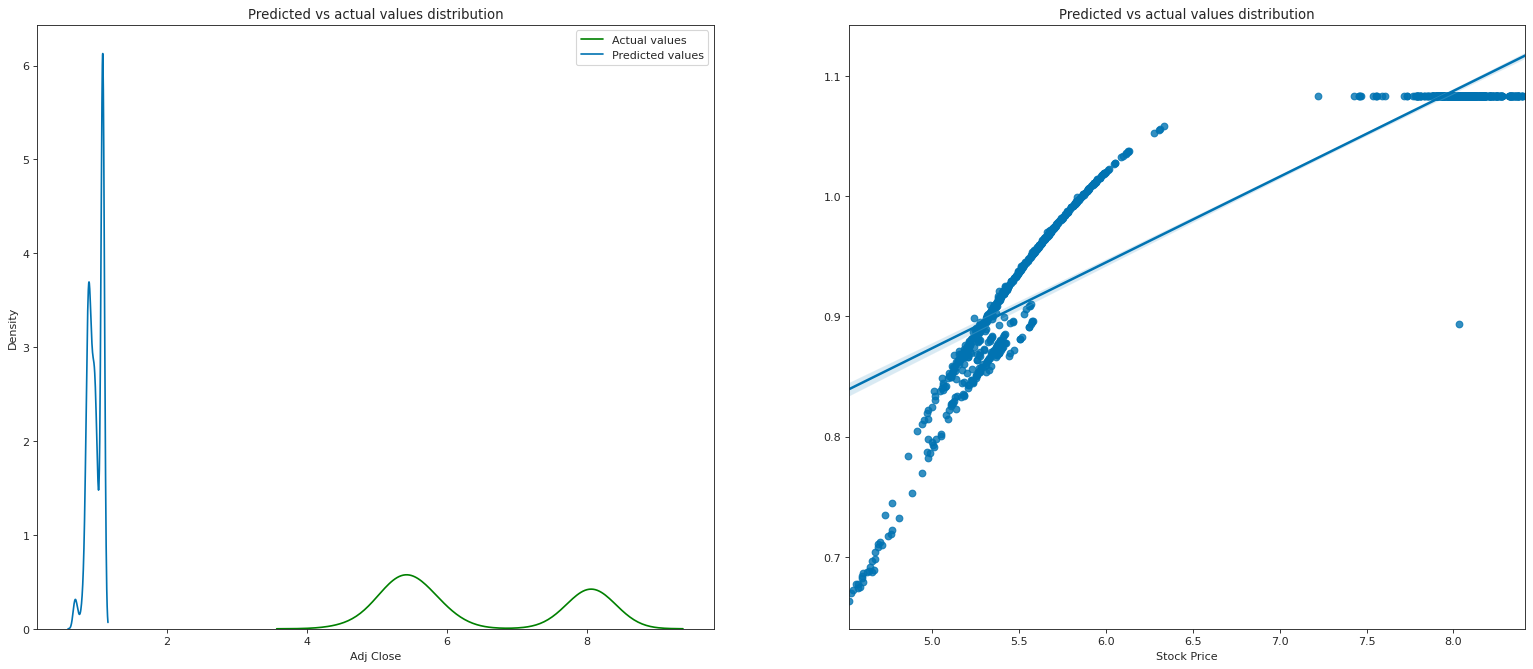

Mean absolute error of <keras.engine.sequential.Sequential object at 0x0000028FA578B910>: 0.07735232671652384


In [275]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=ytest, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predictions2, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=ytest, y=predictions2)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model,mean_abs_error3))

In [276]:
# Train the model part 5 (no activation function)
model.fit(np.array(xtrain).reshape(-1,6,1), ytrain, batch_size =800, epochs=50, verbose=0)

In [279]:
#predictions 
predictions = model.predict(np.array(xtest).reshape(-1,6,1))

36/36 [==============================] - 0s 7ms/step


In [280]:
#calculation of the mean absolute error
mean_abs_error3 = mean_absolute_error(ytest, predictions)
mean_abs_error3

0.07413078517040421

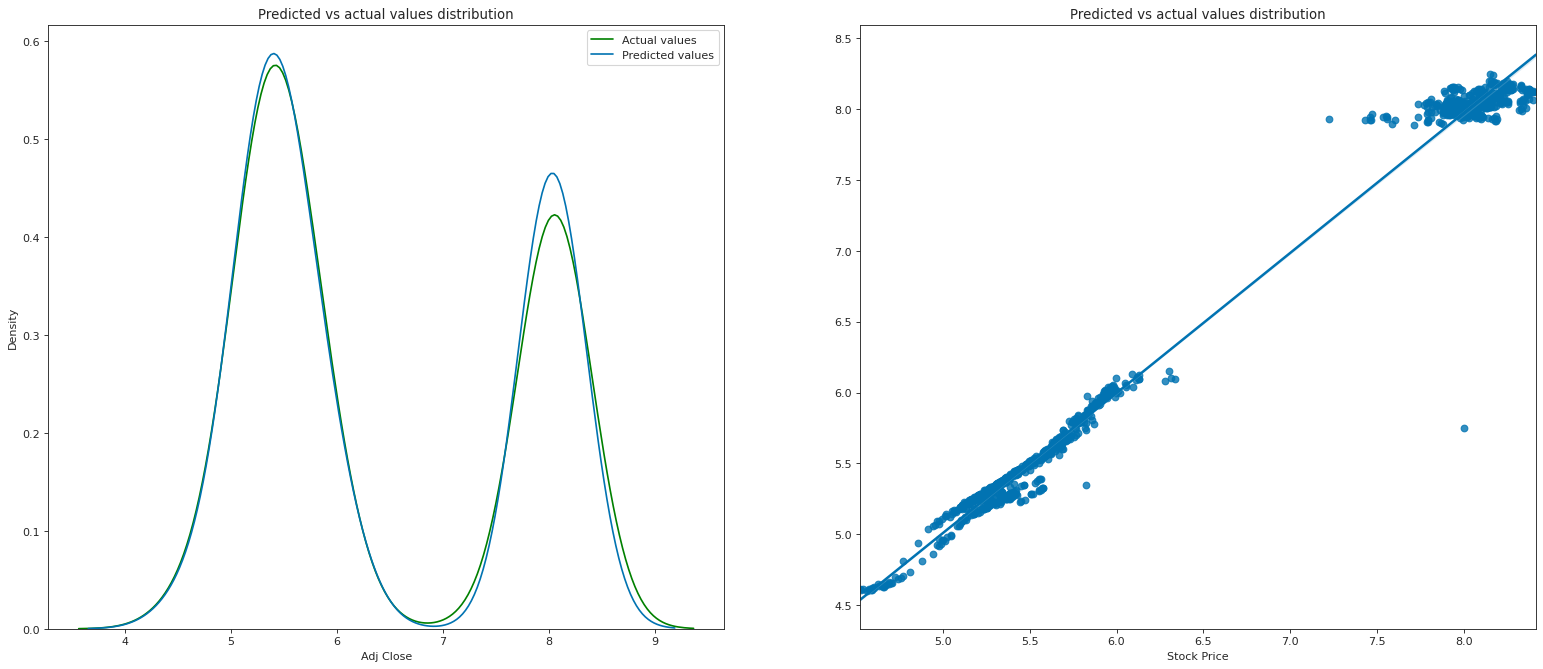

Mean absolute error of <keras.engine.sequential.Sequential object at 0x0000028FA578B910>: 0.07413078517040421


In [281]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=ytest, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predictions, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=ytest, y=predictions)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model,mean_abs_error3))

From the above, we can see that the model is trained and evaluated using `LSTM`. The predicted and actual adjustable stock prices plots look are relatively similar with a mean absolute error of 0.07413 which isn't bad. However, there is still room for improvement and trying out other models to compare.

#### Predicting using Linear Regression

In [282]:
# Building the model for Adj close prediction

y = np.log(df_NWG['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = df_NWG.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4520, 6)
y_train (4520,)
x_test (1130, 6)
y_test (1130,)


In [283]:
#creating an instance of a Linear Regressor 
model_lin = LinearRegression()

#fit the model
model_lin.fit(X_train,y_train)

LinearRegression()

In [284]:
# check the score, coef_ and intercept_ of the model
model_lin.score(X_train,y_train)
model_lin.coef_
model_lin.intercept_

print('The score of the model is {}, the coeficients  are {} and the intercept is {}'.format(model_lin.score(X_train,y_train),model_lin.coef_,model_lin.intercept_))

The score of the model is 0.9726635408788951, the coeficients  are [-5.19307586e-05  6.74828814e-04 -4.40506627e-04  3.05371220e-04
  1.20526851e-10  1.46874545e-01] and the intercept is 4.825316842129244


In [285]:
#prediction
predict = model_lin.predict(X_test)
predict #view some predictions

array([5.47612843, 5.31829307, 8.39477406, ..., 8.30085395, 5.55750502,
       5.599963  ])

In [286]:
#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.1397342376224611

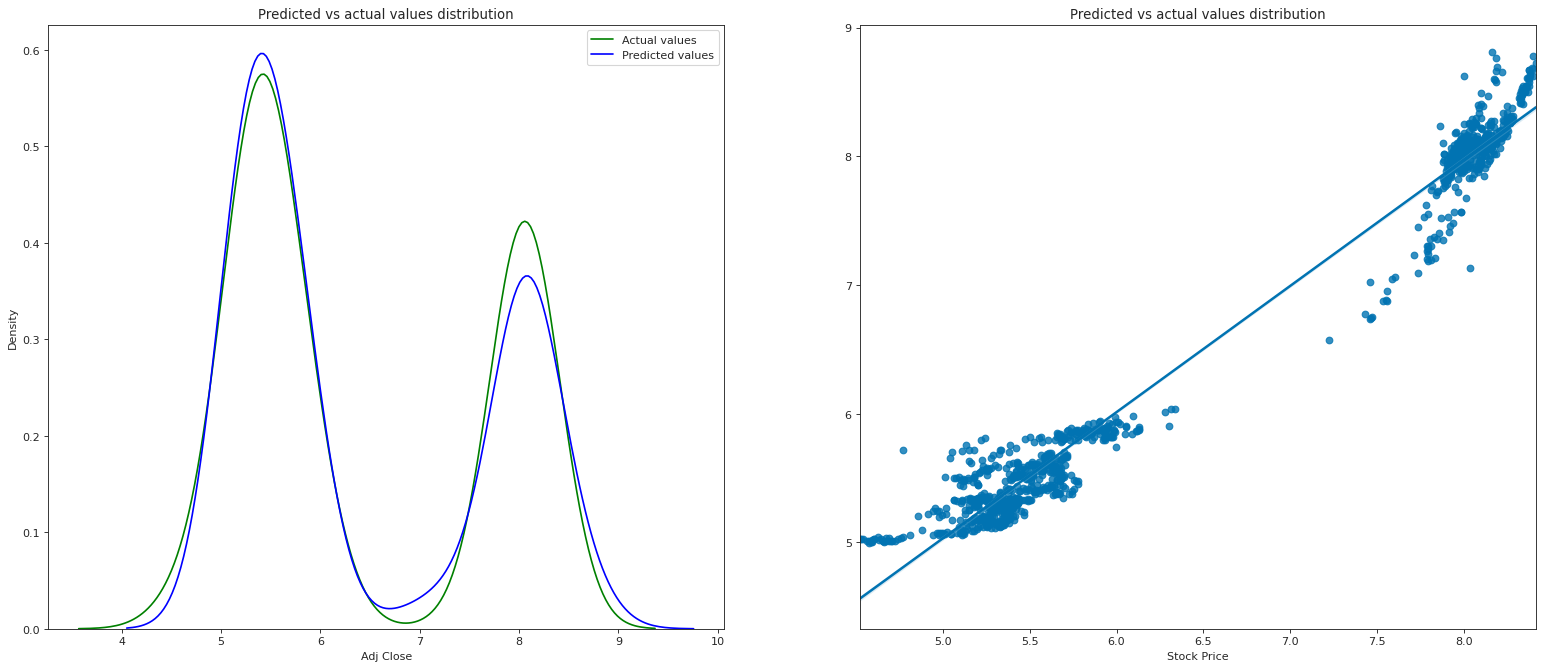

Mean absolute error of LinearRegression(): 0.1397342376224611


In [287]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_lin,mean_abs_error))

From the above, we can see that the model is trained and evaluated using `LinearRegression`. The predicted and actual adjustable stock prices plots have variations but with a mean absolute error is 0.1397 which worse than the LSTM model. However, there is still room for improvement and trying out other models to compare. Let't try out another model and see how it performs.

#### Predicting  using Random Forest Regressor

In [296]:
# Building the model for Adj close prediction

y = np.log(df_NWG['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = df_NWG.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4520, 6)
y_train (4520,)
x_test (1130, 6)
y_test (1130,)


In [297]:
#creating an instance of a Random Forest Regressor 
model_rf = RandomForestRegressor(n_estimators=100, random_state=47)

In [298]:
#fit the model with the training data
model_rf.fit(X_train,y_train)

RandomForestRegressor(random_state=47)

In [299]:
#prediction
predict = model_rf.predict(X_test)
predict #view some predictions

array([5.76484564, 5.30050418, 8.10626427, ..., 8.07737584, 5.56432847,
       5.29577459])

In [300]:
#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.018405552763651946

In [301]:
# view predictions and actual values
#print(np.c_[y_test,predict])
display_ = pd.DataFrame({'Actual value': y_test, 'Predicted value':predict})
display_.head(10)
#print(y_test,predict)

,Actual value,Predicted value
Date,,
2014-11-27,5.765191,5.764846
2017-03-10,5.298317,5.300504
2002-06-18,8.078068,8.106264
2017-11-14,5.411646,5.411646
2015-12-17,5.480639,5.481512
2001-08-22,8.056427,8.065654
2003-02-17,7.892826,7.896987
2015-12-07,5.497168,5.497168
2015-05-29,5.641907,5.641907


From the table, we can see that the `RandomForestRegressor` performed very well and the actual and predicted Adjusted close value are fairly close. Let us now view the plots.

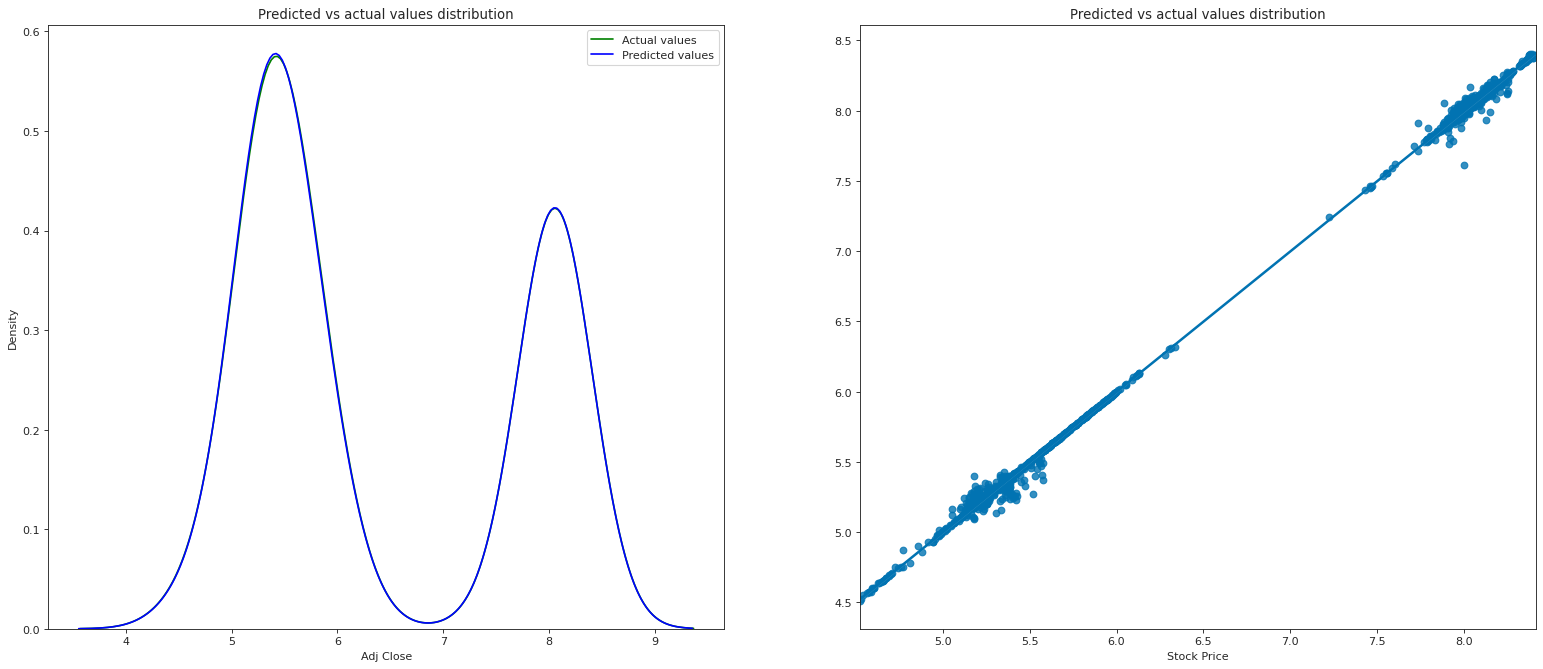

Mean absolute error of RandomForestRegressor(random_state=47): 0.018405552763651946


In [302]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf,mean_abs_error))

From the above, we can see that the model is trained and evaluated using `RandomForestRegressor`. The predicted and actual adjustable stock prices plots look are relatively similar with a mean absolute error is 0.0184 which is good. Let us see how our three models would perform with the Barclays stocks.

### Predicting Adjusted close value of Barclays stocks

In [303]:
# get Barclays data and view the first 5 rows
df_barc = get_data(df_bukfin, 'BARC.L')  
df_barc.head()

,Adj Close,Close,High,Low,Open,Volume,IUDMNIF
Date,,,,,,,
2001-01-01,235.636627,478.499786,488.429993,473.650085,486.813507,0.0,4.0707
2001-01-02,236.887527,481.040100,481.040100,481.040100,481.040100,323352800.0,4.0707
2001-01-03,238.252182,483.811310,483.811310,483.811310,483.811310,485852596.0,3.9272
2001-01-04,249.624634,506.904907,506.904907,506.904907,506.904907,630329754.0,4.0104
2001-01-05,250.193237,508.059601,508.059601,508.059601,508.059601,800015743.0,4.0723


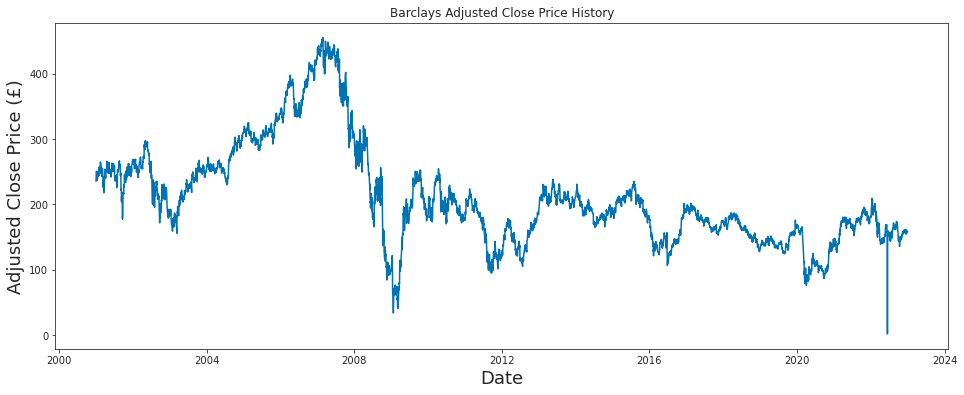

In [305]:
# plot showing Barclays historical Adjusted closing prices
plt.figure(figsize=(16,6))
plt.title('Barclays Adjusted Close Price History')
plt.plot(df_barc['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price (£)', fontsize=18)
plt.show()

In [306]:
# Building the model for Adj close prediction

# create the variables for prediction and split into training and test sets

y = np.log(df_barc['Adj Close'].astype(int)) # we want to predict the adjusted close price
X = df_barc.drop('Adj Close', axis=1) # predictive variables (removing Adj close from it)

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (4520, 6)
y_train (4520,)
x_test (1130, 6)
y_test (1130,)


#### Prediction Using LSTM

In [309]:
#### LSTM Model for Barclays stocks

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model part 5 (no activation function)
model.fit(np.array(X_train).reshape(-1,6,1), y_train, batch_size =800, epochs=50, verbose=0)

#predictions 
predictions = model.predict(np.array(X_test).reshape(-1,6,1))

#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predictions)
mean_abs_error

36/36 [==============================] - 1s 7ms/step


0.06311477637780036

#### Prediction Using Linear Regression

In [310]:
#creating an instance of a Linear Regressor 
model_lin2 = LinearRegression()

#fit the model
model_lin2.fit(X_train,y_train)

#prediction
predict = model_lin2.predict(X_test)

#calculation of the mean absolute error
mean_abs_error = mean_absolute_error(y_test, predict)
mean_abs_error

0.10049462739336858

#### Prediction Using Random Forest Regressor

In [311]:
#creating an instance of a Random Forest Regressor 
model_rf2 = RandomForestRegressor(n_estimators=100, random_state=47)

#fit the model with the training data
model_rf2.fit(X_train,y_train)

#prediction
predict2 = model_rf2.predict(X_test)
predict2 #view some predictions

#calculation of the mean absolute error
mean_abs_error2 = mean_absolute_error(y_test, predict2)
mean_abs_error2

0.018079640025411774

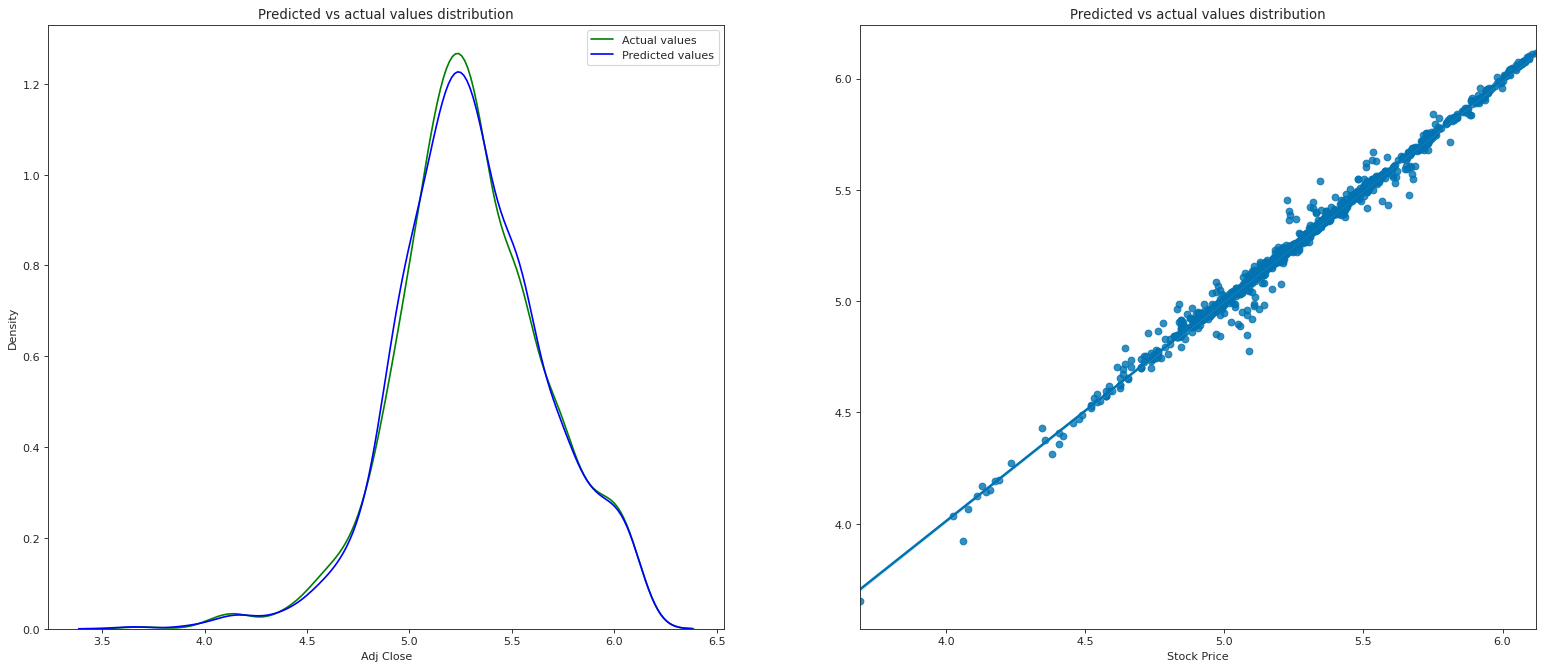

Mean absolute error of RandomForestRegressor(random_state=47): 0.018079640025411774


In [312]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Predicted vs actual values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict2, color="b", label='Predicted values', ax=ax1)
    
sns.regplot(x=y_test, y=predict2)
plt.title('Predicted vs actual values distribution')
plt.xlabel('Stock Price')
#plt.legend()
ax1.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf2,mean_abs_error2))

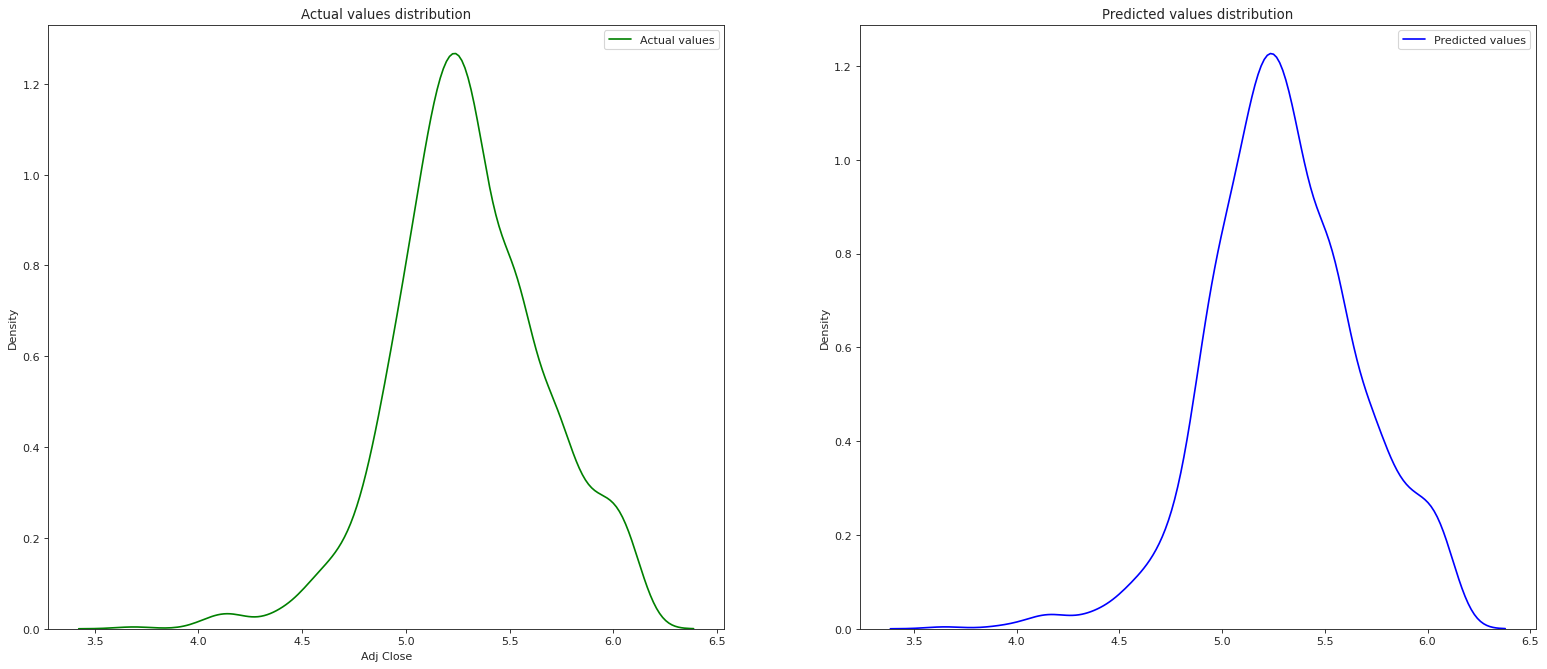

Mean absolute error of RandomForestRegressor(random_state=47): 0.018079640025411774


In [313]:
#plot showing the prediction and actual values

fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=80)
axs[0].set_title('Actual values distribution')
axs[1].set_title('Predicted values distribution')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values',ax=axs[0])
ax2 = sns.kdeplot(data=predict2, color="b", label='Predicted values', ax=axs[1])

ax1.legend()
ax2.legend()
plt.show()
plt.close()
    
print("Mean absolute error of {0}: {1}".format(model_rf2,mean_abs_error2))

From the above, we can see that the model is trained and evaluated using `RandomForestRegressor`. The predicted and actual adjustable Barclays stock prices plots look are very similar with a mean absolute error is 0.01807 which is very good. We can also see that all three models perform better with Barclays than NatWest stocks.

## 4. Results

### Evaluation and Validation of models
From my investigation of three different models, I observed that RandomForestRegressor delivered a much lower mean absolute error (0.018405, 0.01807) than the LSTM (0.07735, 0.0631) or LinearRegression (0.1397, 0.1004) for NatWest and Barclays respectively.  We also observed tuning the parameters for LSTM (e.g the number of epochs and batch_size) resulted in better prediction.

### Interesting facts about the project
When exploring the data, it was interesting to see how the stock prices for the different banks moved at the Great Financial Crisis and how they have trended since. H although .

Here are some major highlights from the data exploration section:

  1. GFC: NatWest had the most dramatic fall in 2008 but has since followed trend with LLoyds and Barclays. HSBC appears to be the stock that has performed the best since the GFC being the only bank to return to its preGFC value
  2. 2019: Before the pandemic we see there isn't much annual grouwth in the stock prices for all 5 banks yet this is still outperforming the FTSE with the exception of HSBC.
  3. 2020: After the crash in Spring 2020 all the banks are hit more than FTSE but Barclays bounces back the fastest.
  4. 2021: All banks except Standard Chartered find price growth in 2021.
  5. 2022: Standard Chartered performed the best in 2022 and Barclays performed the worst. We can see the political issues around uncertainty in leadership and government borrowing from around September 2022 is reflected in the charts. It is difficult to spot a link between forward rates and bank share price from these charts, potentially due to other external events or volatility in forward rate movements.  

### Difficulties encountered
1. Getting the data from yahoo fincance wasn't very obvious. After several research I was able to find an [article](https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e) that guided me on how to obtain the data.
2. The [Machine Learning for Trading course](https://www.udacity.com/course/machine-learning-for-trading--ud501) was also really helpful to knowing more about financial data and how to handle it as well as knowing where to begin my data exploration.
3. Assessing which BoE data to obtain for this purpose.
4. In the modelling part (particularly the LSTM), one would have to spend some time tuning the parameters and training it  to get the best results.

### Improvements
An improvement to my analysis could be the following:
1. Take some significant time to tune the model parameters as well as include more features that might be relevant for stock price prediction.
2. Try out more models and see if there might be one with a better performance than the RandomForestRegressor. I only tried three models for simplicity and time constraints. 
3. Explore other companies stocks to see how well one can predict their stocks prices with different models.